<a href="https://colab.research.google.com/github/Cumberkid/Learning-the-Optimal-Solution-Path/blob/main/experiments/fair-regression/notebooks/05%20Visualize%20Learn%20Solution%20Path%20(CCP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader  #for creating the dataset


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
import pandas as pd

In [ ]:
# import importlib

## Import our own modules

In [ ]:
# !rm -r Learning-the-Optimal-Solution-Path
!git clone https://github.com/Cumberkid/Learning-the-Optimal-Solution-Path.git

Cloning into 'Learning-the-Optimal-Solution-Path'...
remote: Enumerating objects: 542, done.
remote: Counting objects: 100% (352/352), done.
remote: Compressing objects: 100% (239/239), done.
remote: Total 542 (delta 199), reused 180 (delta 105), pack-reused 190
Receiving objects: 100% (542/542), 10.99 MiB | 24.96 MiB/s, done.
Resolving deltas: 100% (295/295), done.


(Using Colab)

In [ ]:
import sys

In [ ]:
# Add the parent directory to sys.path
sys.path.append('/content/Learning-the-Optimal-Solution-Path')

In [ ]:
import lib
# importlib.reload(lib)

In [ ]:
from lib.utils_data import Regression_Data
from lib.lsp.basis_generator import phi_lam_legendre
from lib.lsp.basis_tf_module import Basis_TF_SGD
from lib.lsp.fair_reg_solver_sgd import fair_train_sgd, fair_test_sgd

#Learning the Solution Path Through SGD
Now, let us run SGD over random $\tilde λ$'s with a linear basis $\Phi(\tilde \lambda)$ of our choice. We want to approximate $\theta$ with $\Phi(\lambda)\beta$, so the objective function is $\min_\beta h(\Phi(\tilde\lambda)\beta, \tilde\lambda) = (1-\tilde\lambda) BCE(X_\text{pass}\Phi(\tilde\lambda)\beta,\ y_\text{pass}) + \tilde\lambda BCE(X_\text{fail}\Phi(\tilde\lambda)\beta,\ y_\text{fail})$. For each batch of training data set, we randomize $\tilde\lambda$. If batch size = 1, then this is equivalent to a standard SGD.

In [ ]:
# file path for Colab. May need to change this
X_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/X_processed.csv')
y_df = pd.read_csv('/content/Learning-the-Optimal-Solution-Path/experiments/fair-regression/data/y_processed.csv')

In [ ]:
X = np.array(X_df)
y = np.array(y_df).squeeze()

In [ ]:
full_data = Regression_Data(X, y)
# full gradient descent uses all data points
GD_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=True, )
# stochastic gradient descent uses mini-batch
SGD_data_loader = DataLoader(full_data, batch_size=20, shuffle=True, )
# test data
test_data_loader = DataLoader(full_data, batch_size=len(full_data), shuffle=False, )

In [ ]:
lam_max = 1
lam_min = 0
input_dim = X.shape[1]
criterion=torch.nn.BCELoss()

## Our Model

We use Legendre polynomials with degree $\leq n$ as the basis vectors for $\Phi(\lambda)$.

In [ ]:
phi_lam = phi_lam_legendre

In [ ]:
criterion = torch.nn.BCELoss()
input_dim = X.shape[1]

# Visualizing convergence of our model

We use a coefficient profile plot for an arbitrarily selected coefficient (3) to visualize the convergence of our model.

In [ ]:
num_grid = 2**10
lambdas = np.linspace(lam_max, lam_min, num_grid)
delta_lam = (lam_max - lam_min)/(num_grid - 1)

In [ ]:
coeff_index = 3

In [ ]:
trace = 200 # run this again before plotting

#### Coefficient plot when we use exact gradient.

In [ ]:
# build the model
basis_dim = 7
epoch = trace * (2**3)
lr = 0.5

np.random.seed(8675309)
torch.manual_seed(8675309)
model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    fair_train_SGD(GD_data_loader, model, criterion, optimizer)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [ ]:
thetas_SGD.shape

(1024, 46)

In [ ]:
trace = 200 # run this again before plotting

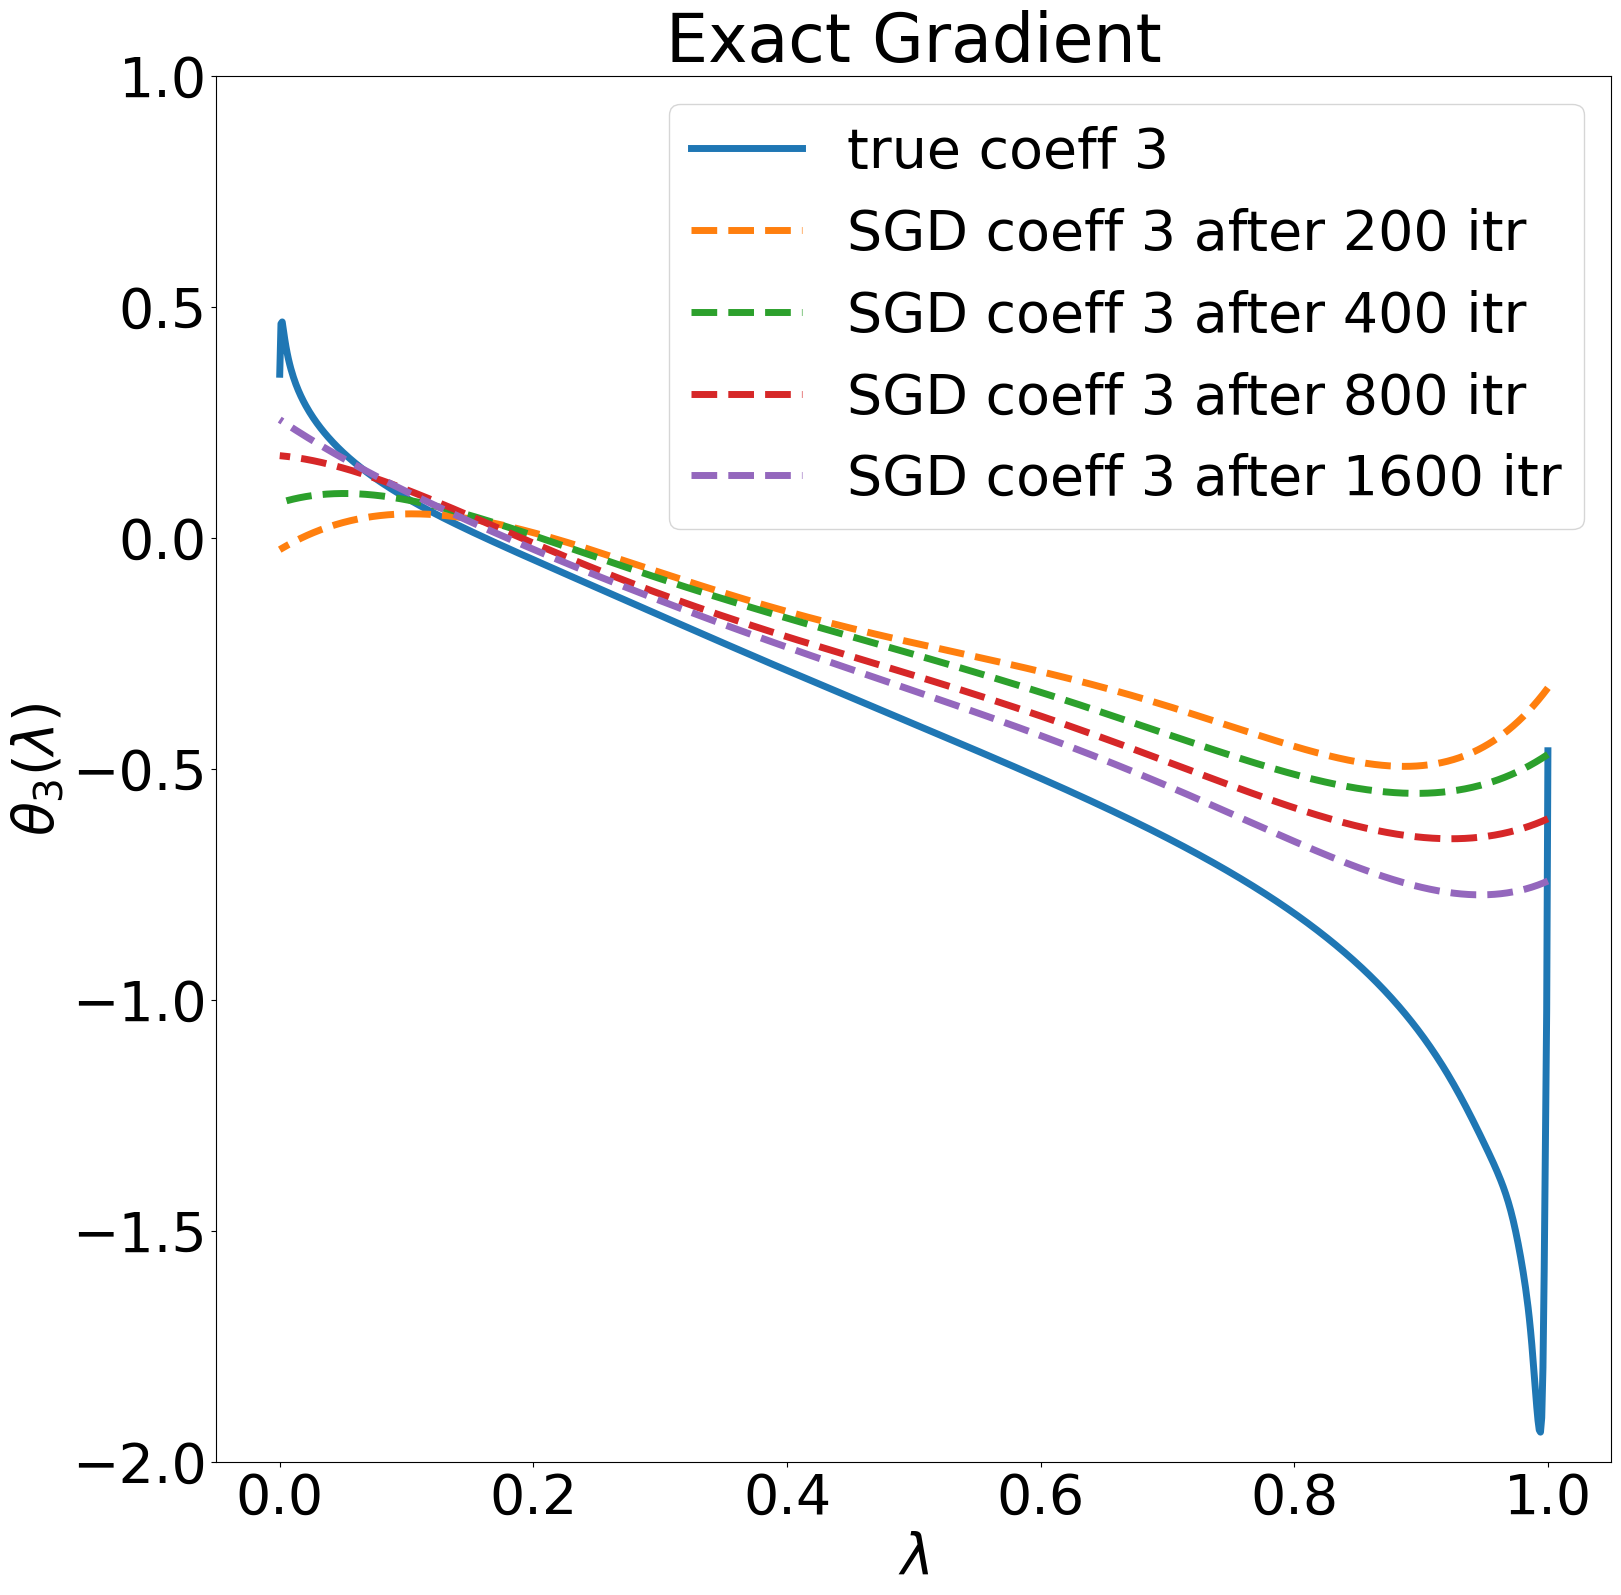

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=5, label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=5, label=f'SGD coeff {coeff_index} after {trace*(2**i)} itr')

# Set global font size
mpl.rcParams['font.size'] = 40

font_size = 40
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel('$\\theta_{3}(\\lambda)$', fontsize=font_size)

plt.title('Exact Gradient')

plt.ylim(-2, 1)
# Add legend
plt.legend(fontsize=font_size)

# Show the plot
plt.show()

# save figure
plt.savefig("CPP_exact_3.png")


### Coefficient profile plot when we use noisy gradient

In [ ]:
# build the model
basis_dim = 7
epoch = trace * (2**3)
alpha = 2**4

np.random.seed(8675309)
torch.manual_seed(8675309)
model = Basis_TF_SGD(input_dim, basis_dim, phi_lam, intercept=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer.zero_grad()
thetas_SGD_history = []
for t in range(epoch):
    # shrink learning rate
    lr = min([0.1, alpha/(t+1)])
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    fair_train_SGD(SGD_data_loader, model, criterion, optimizer)
    if (t+1) == trace:
        trace = 2*trace
        thetas_SGD = []
        for lam in lambdas:
            thetas_SGD.append(model(lam).data.cpu().detach().numpy())
        thetas_SGD = np.array(thetas_SGD)
        thetas_SGD_history.append(thetas_SGD)

In [ ]:
trace = 200 # run this again before plotting

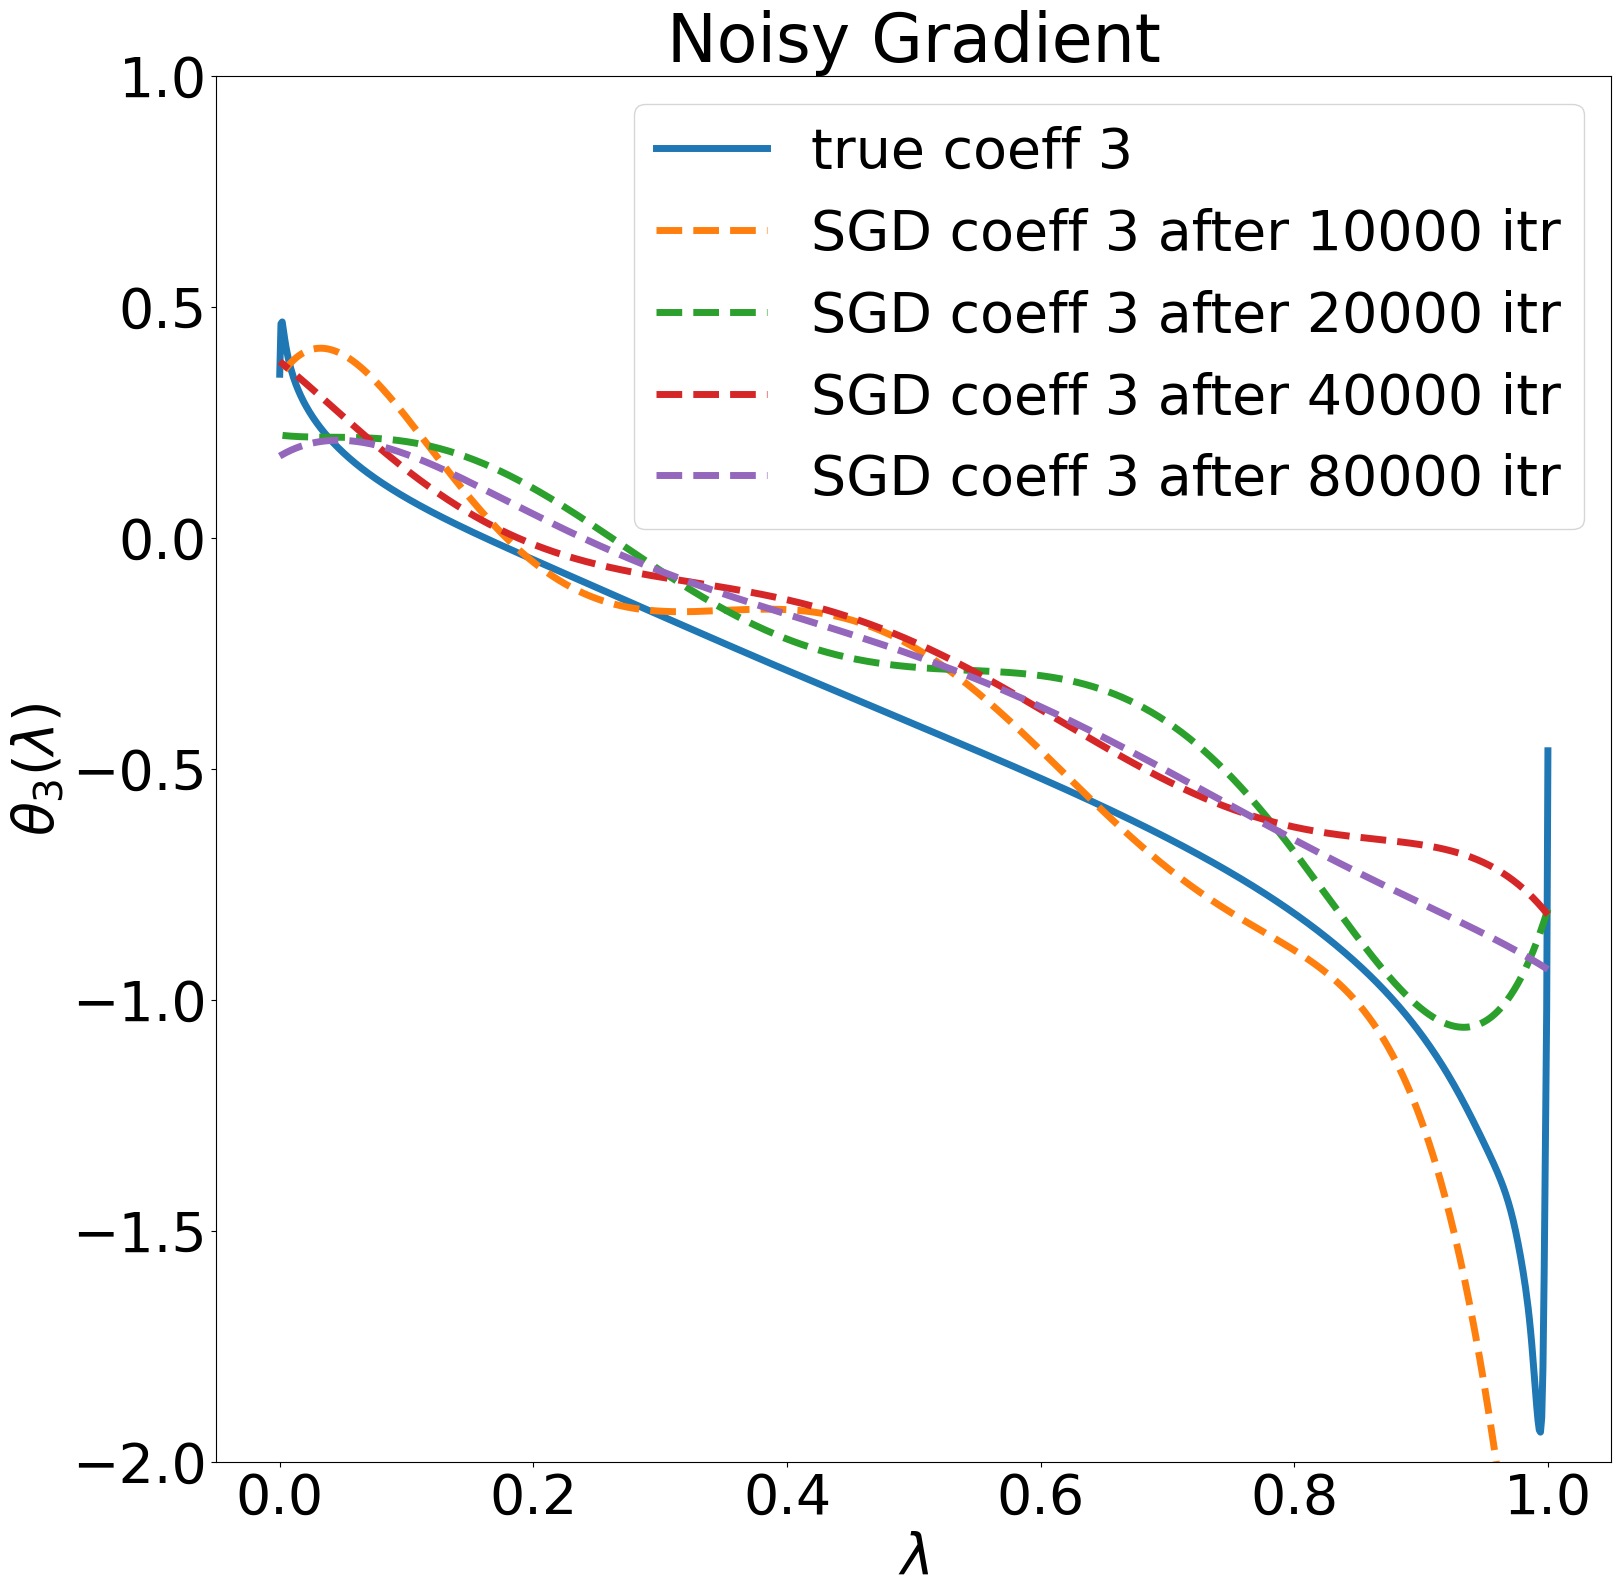

In [ ]:
# Create a Matplotlib plot
plt.figure(figsize=(18, 18))
plt.plot(lambdas, true_thetas[:,coeff_index], linewidth=5, label=f'true coeff {coeff_index}')

for i in range(0, len(thetas_SGD_history)):
    plt.plot(lambdas, thetas_SGD_history[i][:,coeff_index], '--', linewidth=5, label=f'SGD coeff {coeff_index} after {50*trace*(2**i)} itr')

# Set global font size
mpl.rcParams['font.size'] = 40

font_size = 40
# Tick labels
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Legend, if applicable
plt.legend(fontsize=font_size)

# Set plot labels and title
# plt.xscale('log')  # Log scale for the x-axis
plt.xlabel('$\\lambda$', fontsize=font_size)
plt.ylabel('$\\theta_{3}(\\lambda)$', fontsize=font_size)
plt.title('Noisy Gradient')

plt.ylim(-2, 1)

# Show the plot
# plt.show()

# save figure
plt.savefig("CPP_noisy_3.png")